In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download soumikrakshit/nyu-depth-v2

In [ ]:
!unzip /content/nyu-depth-v2.zip -d /content

In [ ]:
!unzip /content/drive/MyDrive/pothole600_v3.zip -d pothole600_v3

In [1]:
import os

import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# import tensorflow_addons as tfa
from tensorflow.keras import Model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet169, DenseNet201
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPool2D, Dropout, BatchNormalization, Conv2DTranspose, LeakyReLU, concatenate, Input, Activation






In [2]:
#Set seed value
seed_value = 43

os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

#numpy seed
np.random.seed(seed_value)

#Tf seed
tf.random.set_seed(seed_value)

#Configure new global tensorflow session
from tensorflow.compat.v1.keras import backend as k
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads = 1,
    inter_op_parallelism_threads = 1
)

sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = session_conf)
k.set_session(sess)

In [3]:
def get_df(path):

    image = [f'{path}/rgb/{i}' for i in next(os.walk(f'{path}/rgb'))[2]]
    tdisp_map = [f'{path}/tdisp/{i}' for i in next(os.walk(f'{path}/tdisp'))[2]]
    df = pd.DataFrame(columns=['image', 'depth'])
    df['image'] = image
    df['depth'] = tdisp_map
    return df


In [4]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, dataframe, batch_size, shuffle=False, dim=(320,320)):
    # for reproducibility
    np.random.seed(43)
    # dataframe containing the subset of image and depth pairs
    self.df = dataframe
    # chosen Height and Width of the RGB image
    self.height, self.width = dim
    # choice of shuffling the data
    self.shuffle = shuffle
    self.batch_size = batch_size
    # unique set of RGB images
    self.ids = dataframe['image'].unique()
    # Map the image with depth maps
    self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
    self.on_epoch_end()

  def __len__(self):
    '''
    Returns the length of dataset.
    '''
    return len(self.df) // self.batch_size

  def on_epoch_end(self):
    '''
    Shuffles the data at the end of every epoch
    '''
    self.indexes = np.arange(len(self.ids))
    if self.shuffle:
      np.random.shuffle(self.indexes)
  
  def __getitem__(self,index):
    '''
    returns the batch of image and depth pairs 
    '''
    # select the batch of pair indexes 
    idxs = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
    # randomly select whether to flip the image
    flip = np.random.choice([True, False])
    # select the image id's for the above indexes
    query_imgs = [self.ids[idx] for idx in idxs]
    # select corresponding depth pair for the image
    target_imgs = [self.imgtodpth[img] for img in query_imgs]
    # preprocess the image 
    processed_query_img = self._preprocess_image(query_imgs, flip)
    # preprocess the depth map
    processed_depth_img = self._preprocess_depth(target_imgs, flip)
    return processed_query_img, processed_depth_img

  def _preprocess_image(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the image set. 
    '''
    # placeholder for storing the processed images
    processed = []
    for img in images:
      # resize the image to 640x480
      resized_img = cv2.resize(cv2.imread(img),(self.height,self.width)).astype(np.float32)
      # normalize the image to {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # finally append each image
      processed.append(scaled_img)
    return np.array(processed)

  def _preprocess_depth(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the depth maps.
    '''
    # placeholder for storing the processed depth maps
    processed = []
    for img in images:
      # resize the depth map to 320x240
      resized_img = cv2.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY),(320,320)).astype(np.float32)
      # normalize it to range {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # add the color channel as cv2 grayscale image doesnt contain color channel but tensorflow expects it
      scaled_img = np.expand_dims(scaled_img, axis=-1)
      # finally append the image
      processed.append(scaled_img)
    return np.array(processed)
    


In [5]:


def conv2d_block(input_tensor, n_filters, kernel_size = 3, activation='relu', batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    return x



def upsampling(input_tensor, n_filters, concat_layer, activation='relu'):
    '''
    Block of Decoder
    '''
    x = Conv2DTranspose(n_filters, (3, 3), strides = (2, 2), padding = 'same')(input_tensor)
    x = concatenate([x, concat_layer])
    x = Dropout(0.2)(x)
    x = conv2d_block(x, n_filters, kernel_size = 3, activation=activation, batchnorm = True)
    return x


def DenseNet_UNET(n_filters, activation):


    ########################################################

                    #ENCODER#

    # Layer name of encoders to be concatenated
    names = ['pool3_pool', 'pool2_pool', 'pool1','conv1/relu']
    # Transfer learning approach without the classification head
    encoder = DenseNet201(include_top=False, weights='imagenet', input_shape=(320,320,3))
    for layer in encoder.layers:
      layer.trainable = True
      inputs = encoder.input
      x = encoder.output

                    #ENCODER#

    ########################################################


    ########################################################

                    #bottleneck#


    # decoder blocks linked with corresponding encoder blocks
    bneck = Conv2D(filters=n_filters*16, kernel_size=(1,1), padding='same')(x)
    x = Activation(activation)(bneck)                    

                    #bottleneck#

    ########################################################


    ########################################################

                    #DECODER#

    x = upsampling(input_tensor=bneck, n_filters=n_filters*16, activation=activation, concat_layer=encoder.get_layer(names[0]).output)
    x = upsampling(input_tensor=x, n_filters=n_filters*8, activation=activation, concat_layer=encoder.get_layer(names[1]).output)
    x = upsampling(input_tensor=x, n_filters=n_filters*4, activation=activation, concat_layer=encoder.get_layer(names[2]).output)
    x = upsampling(input_tensor=x, n_filters=n_filters*2, activation=activation, concat_layer=encoder.get_layer(names[3]).output)
    x = Conv2DTranspose(n_filters*2, (3, 3), strides = (2, 2), padding = 'same')(x)
    x = Activation(activation)(x)
    x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

                    #DECODER#

    ########################################################

    model = Model(inputs=inputs, outputs=x)
    return model

In [6]:


def loss_function(y_true, y_pred):

  #Cosine distance loss
  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
  
  # edge loss for sharp edges
  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
  
  # structural similarity loss
  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  # weightage
  w1, w2, w3 = 1.0, 1.0, 0.1
  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))



#optimizer
opt = Adam(learning_rate=0.0001, decay=1e-6,amsgrad=True)

# accuracy function
def accuracy_function(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# save model frequently for later use.
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/GRAY_DEPTH-MODEL-WITH-nyu-depth-ex1.h5',
                                                save_best_only=True,
                                                verbose=1)
# Learning rate scheduler
def polynomial_decay(epoch):
  max_epochs = 10
  base_lr =  0.0001
  power = 1.0
  lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
  return lr

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint]

In [7]:
train_df = pd.read_csv('/content/data/nyu2_train.csv',header=None)
# test = pd.read_csv('/content/data/nyu2_test.csv',header=None).rename(columns={0:'image', 1:'depth'})
train_df = train_df.sample(frac=1).reset_index(drop=True).rename(columns={0:'image', 1:'depth'})
# train_df = train_df.head(5)
train_df = train_df.iloc[:2500, :]
train_split = int(len(train_df)*0.5)


train = train_df[:train_split]
validation = train_df[train_split:]
len(train), len(validation)

(1250, 1250)

In [8]:
train = get_df('/content/pothole600_v3/training')
full_train = pd.concat([train, train_df], axis=0).reset_index(drop=True)
full_train.shape

(3820, 2)

In [9]:
val = get_df('/content/pothole600_v3/validation')
full_val = pd.concat([val, validation], axis=0).reset_index(drop=True)
full_val.shape

(1330, 2)

In [10]:
test = get_df('/content/pothole600_v3/testing')

In [11]:
train_generator = DataGenerator(full_train, batch_size=12, shuffle=True, dim=(320,320))
val_generator = DataGenerator(full_val, batch_size=12, shuffle=False, dim=(320,320))
test_generator = DataGenerator(test, batch_size=5, shuffle=False, dim=(320,320))
print(len(train_generator), len(val_generator), len(test_generator))

318 110 16


In [12]:
images,depths = next(iter(val_generator))
print(images.shape, depths.shape)

(12, 320, 320, 3) (12, 320, 320, 1)


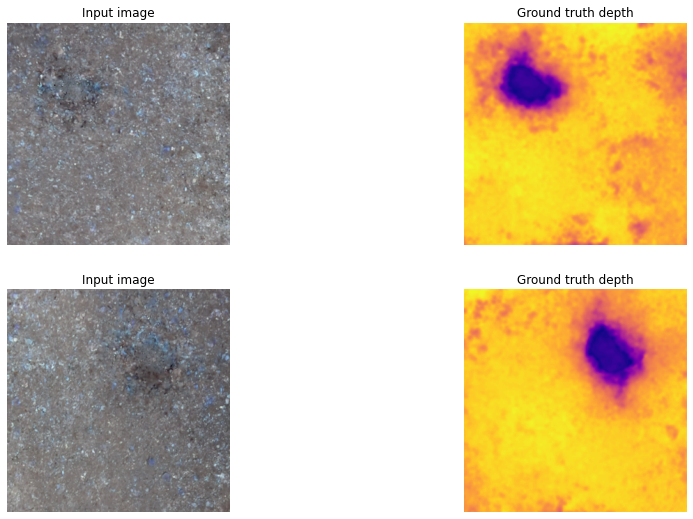

In [13]:
cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
  image = images[i]
  depth = depths[i].squeeze(-1)
  plt.subplot(221+i)
  plt.axis('off')
  plt.imshow(image)
  plt.title('Input image')
  plt.subplot(222+i)
  plt.axis('off')
  plt.imshow(depth,cmap=plt.get_cmap(cmap))
  plt.title('Ground truth depth')

In [14]:
model = DenseNet_UNET(64, LeakyReLU(0.2))


In [15]:
model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function])
history = model.fit(train_generator, validation_data=val_generator, epochs=10,callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/10
318/318 [==============================] - ETA: 0s - loss: 0.2162 - accuracy_function: 0.6744
Epoch 1: val_loss improved from inf to 0.18713, saving model to /content/drive/MyDrive/GRAY_DEPTH-MODEL-WITH-nyu-depth-ex1.h5
318/318 [==============================] - 465s 1s/step - loss: 0.2162 - accuracy_function: 0.6744 - val_loss: 0.1871 - val_accuracy_function: 0.7159 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9e-05.
Epoch 2/10
318/318 [==============================] - ETA: 0s - loss: 0.1647 - accuracy_function: 0.7695
Epoch 2: val_loss improved from 0.18713 to 0.13346, saving model to /content/drive/MyDrive/GRAY_DEPTH-MODEL-WITH-nyu-depth-ex1.h5
318/318 [==============================] - 425s 1s/step - loss: 0.1647 - accuracy_function: 0.7695 - val_loss: 0.1335 - val_accuracy_function: 0.8083 - lr: 9.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 8e-05.
Epoch 3

In [16]:
model.evaluate(test_generator)

16/16 [==============================] - 9s 216ms/step - loss: 0.1228 - accuracy_function: 0.9365


[0.12279733270406723, 0.9365008473396301]

In [17]:
images,labels = next(iter(test_generator))
preds = model.predict(images)

1/1 [==============================] - 4s 4s/step


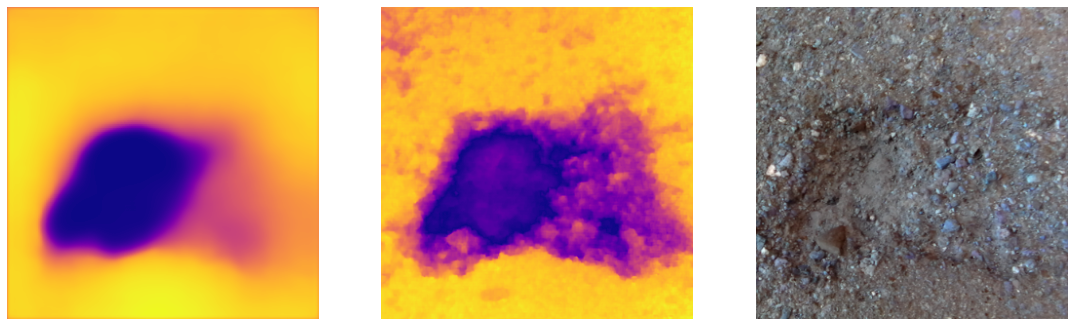

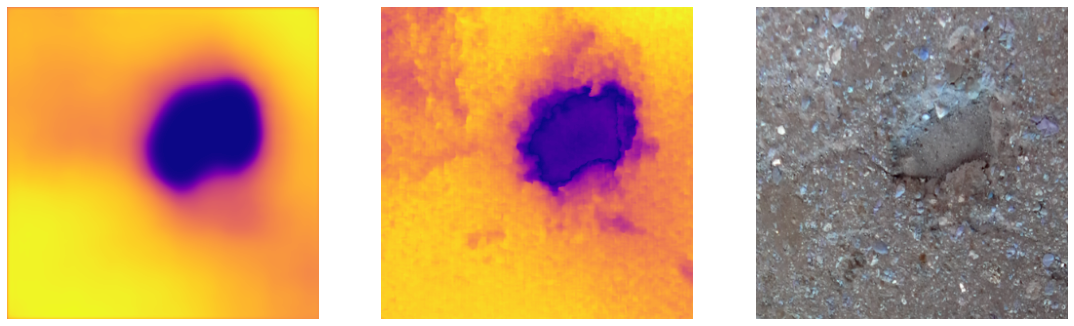

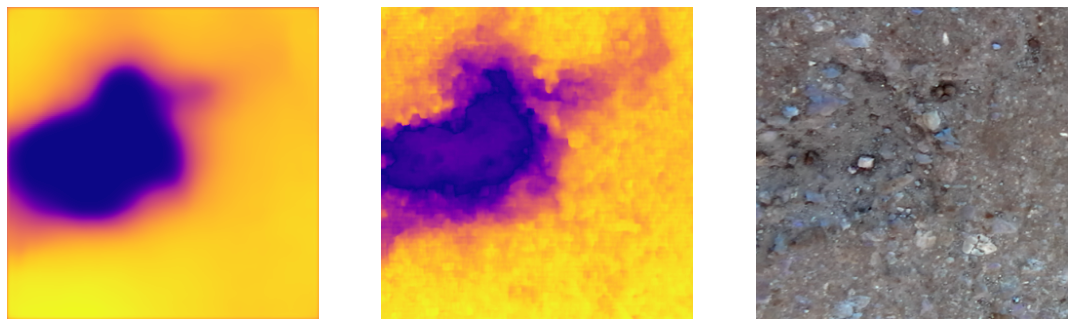

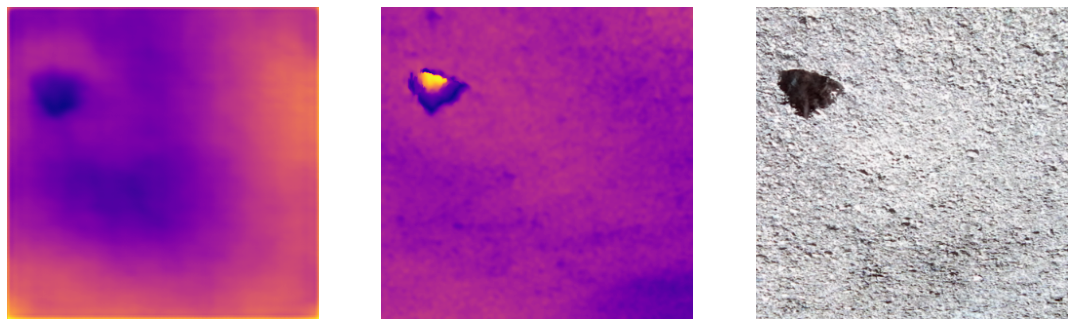

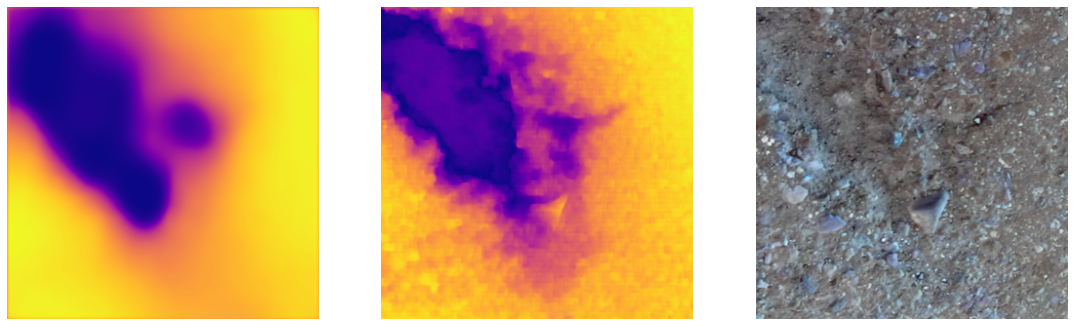

In [18]:
cmap = "plasma_r"


for i in range(len(images)):
  plt.figure(figsize=(19,10))
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)
  plt.subplot(1,3,1)
  plt.axis("off")
  plt.imshow(pred, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,2)
  plt.axis("off")
  img = labels[i]
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,3)
  plt.axis("off")
  img1 = images[i]
  plt.imshow(img1)

  plt.show()